In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
import plotly.express as px

In [2]:
script_dir = Path('__file__').resolve().parent
data_path = script_dir.joinpath('data')

df_holidays = pd.read_csv(data_path.joinpath('holidays_events.csv'))
df_oil = pd.read_csv(data_path.joinpath('oil.csv'))
df_stores = pd.read_csv(data_path.joinpath('stores.csv'))
df_transactions = pd.read_csv(data_path.joinpath('transactions.csv'))
df_test = pd.read_csv(data_path.joinpath('test.csv'))
df_train = pd.read_csv(data_path.joinpath('train.csv'))

# Exploratory Analysis

In [3]:
df_train.info()
print(df_train.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
id       date        store_nbr  family                      sales  onpromotion
3000887  2017-08-15  9          SEAFOOD                     16.0   0              1
0        2013-01-01  1          AUTOMOTIVE                  0.0    0              1
1        2013-01-01  1          BABY CARE                   0.0    0              1
2        2013-01-01  1          BEAUTY                      0.0    0              1
3        2013-01-01  1          BEVERAGES                   0.0    0              1
                                                                                 ..
27       2013-01-01  1          P

In [4]:
df_holidays.info()
print(df_holidays.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
date        type        locale    locale_name  description                    transferred
2017-12-26  Additional  National  Ecuador      Navidad+1                      False          1
2012-03-02  Holiday     Local     Manta        Fundacion de Manta             False          1
2012-04-01  Holiday     Regional  Cotopaxi     Provincializacion de Cotopaxi  False          1
2012-04-12  Holiday     Local     Cuenca       Fundacion de Cuenca            False          1
2012-04-14  Holiday     Local     Libertad     C

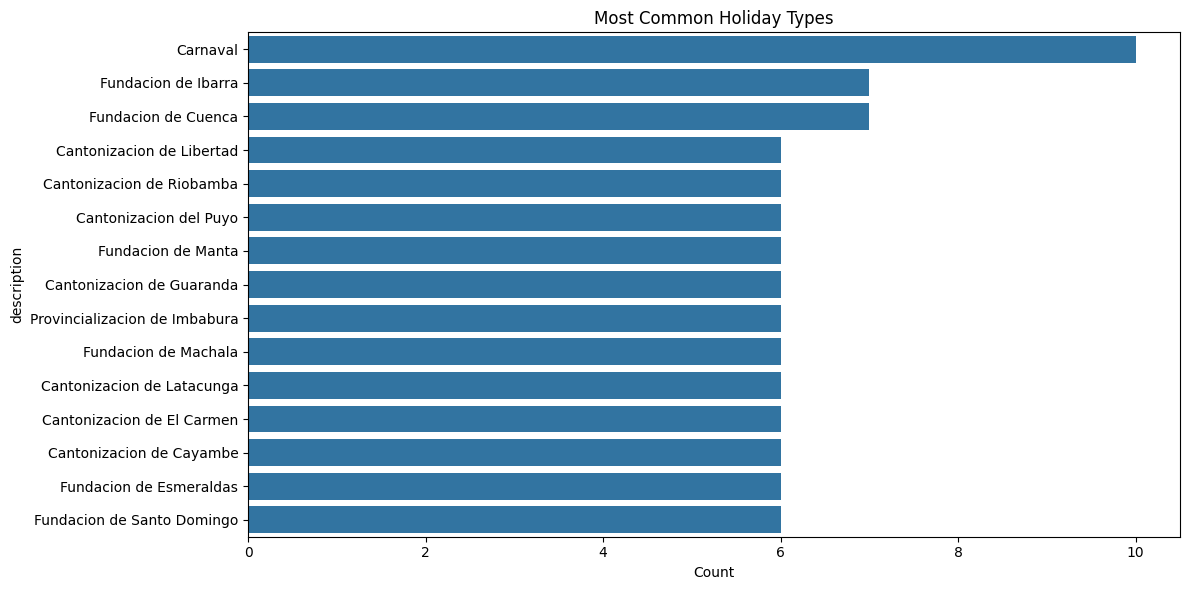

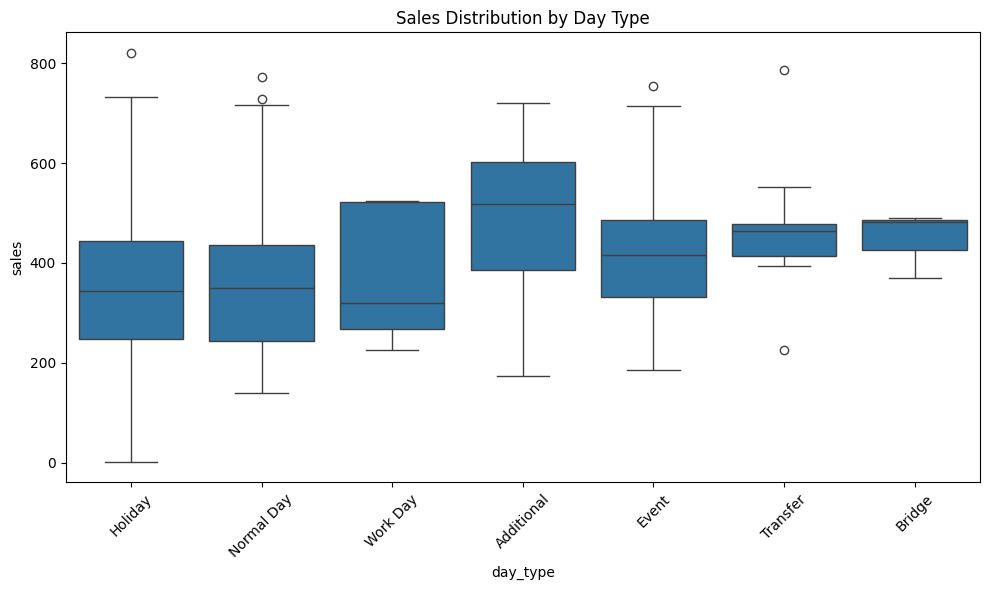

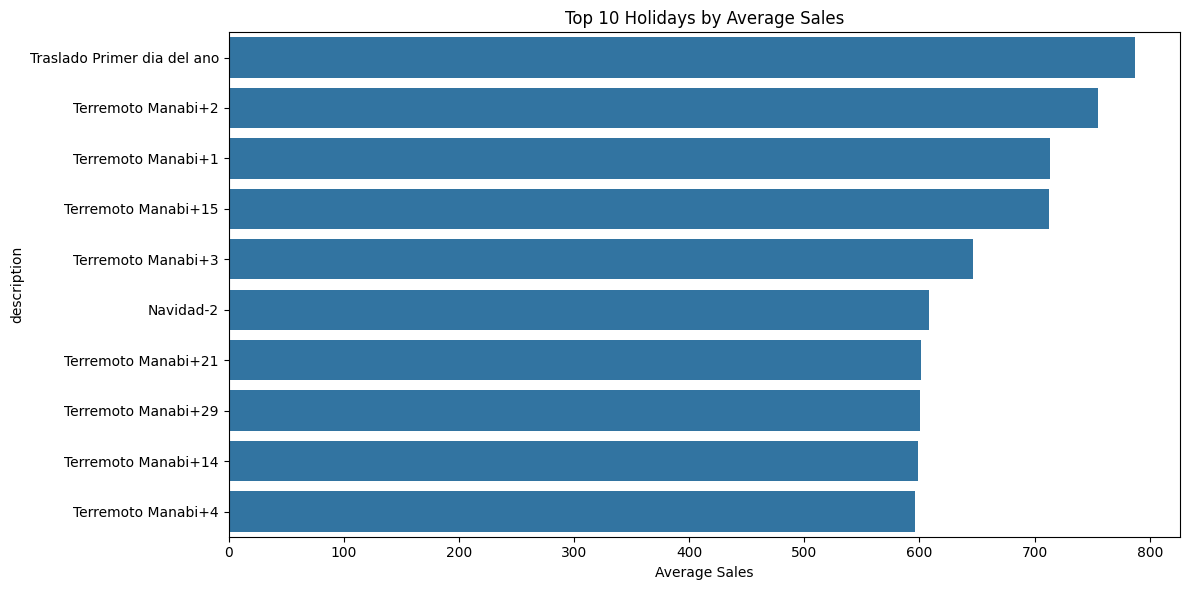

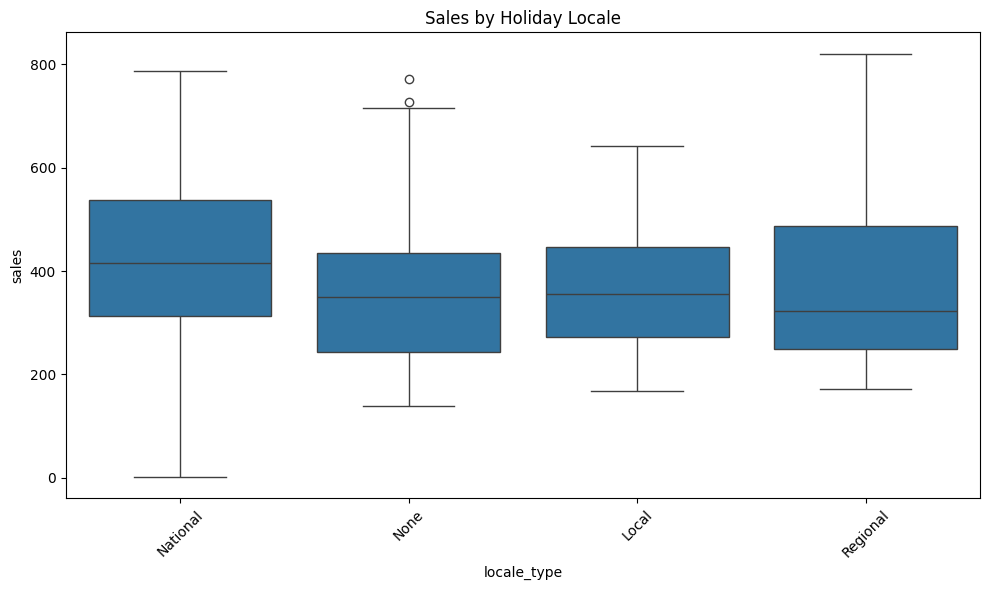

In [5]:
# Convert date to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

# Create a visualization of most common holiday descriptions
plt.figure(figsize=(12, 6))
top_holidays = df_holidays.description.value_counts().head(15)
sns.barplot(x=top_holidays.values, y=top_holidays.index)
plt.title('Most Common Holiday Types')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# Group sales by date and calculate daily average
daily_sales = df_train.groupby('date')['sales'].mean().reset_index()

# Merge with holidays data to identify holiday dates
sales_with_holidays = pd.merge(daily_sales, df_holidays[['date', 'type', 'locale', 'description']], 
                              on='date', how='left')

# Create a day type category
sales_with_holidays['day_type'] = 'Normal Day'
sales_with_holidays.loc[~sales_with_holidays['type'].isna(), 'day_type'] = sales_with_holidays['type']

# Compare sales by day type
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_type', y='sales', data=sales_with_holidays)
plt.title('Sales Distribution by Day Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 holiday types by sales
holiday_sales = sales_with_holidays[~sales_with_holidays['description'].isna()]
top_holiday_sales = holiday_sales.groupby('description')['sales'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_holiday_sales.values, y=top_holiday_sales.index)
plt.title('Top 10 Holidays by Average Sales')
plt.xlabel('Average Sales')
plt.tight_layout()
plt.show()

# Compare National vs Local holidays
sales_with_holidays['locale_type'] = sales_with_holidays['locale'].fillna('None')
plt.figure(figsize=(10, 6))
sns.boxplot(x='locale_type', y='sales', data=sales_with_holidays)
plt.title('Sales by Holiday Locale')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

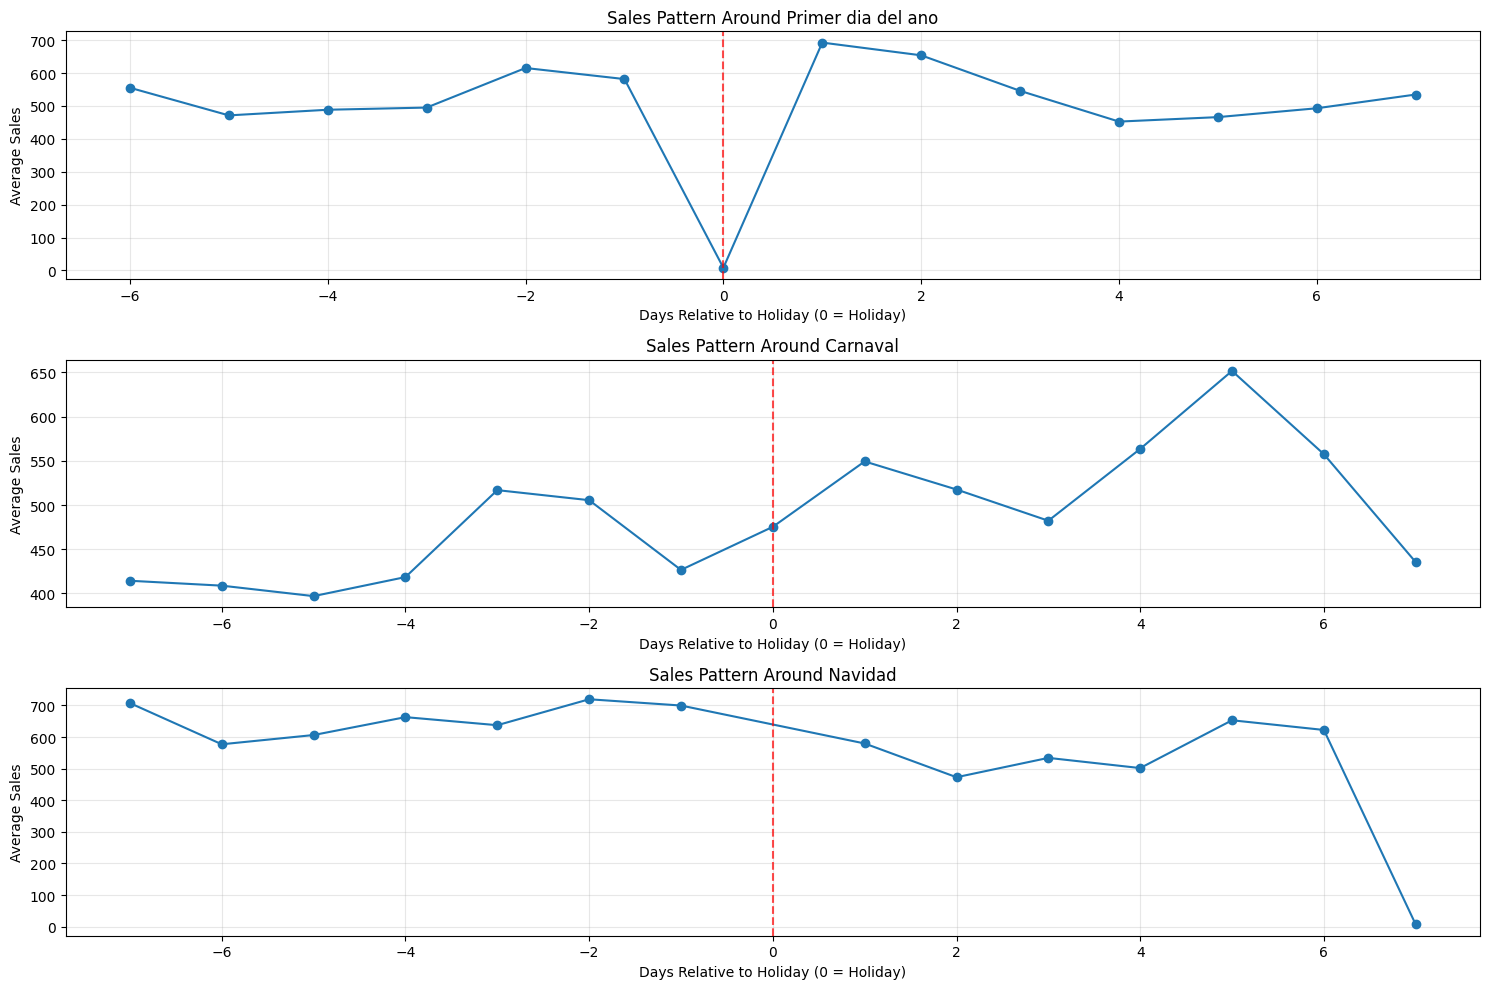

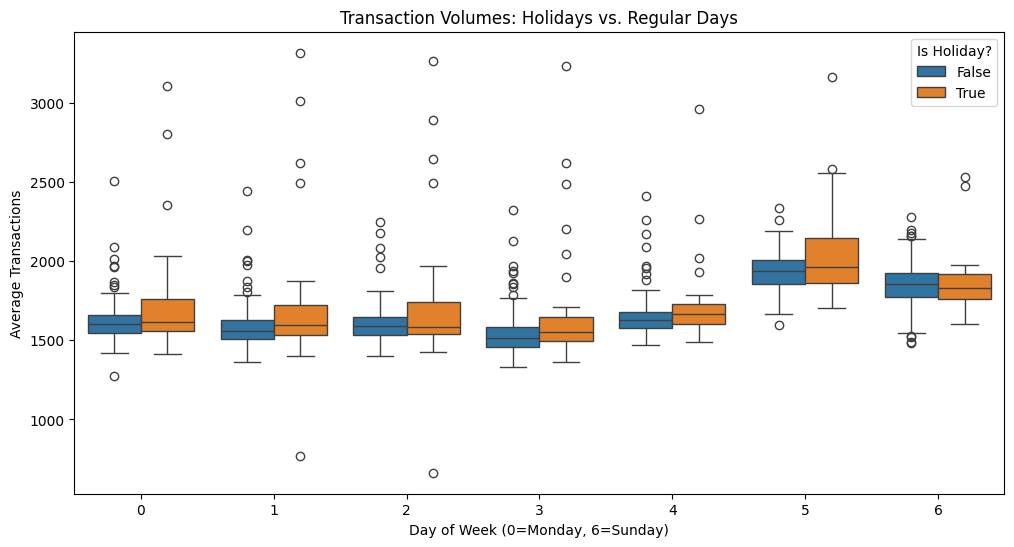

C:\Users\gupes\AppData\Local\Temp\ipykernel_22340\3324000853.py:126: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=holiday_effect, x='days_from_holiday', y='sales', hue='locale', ci=None)


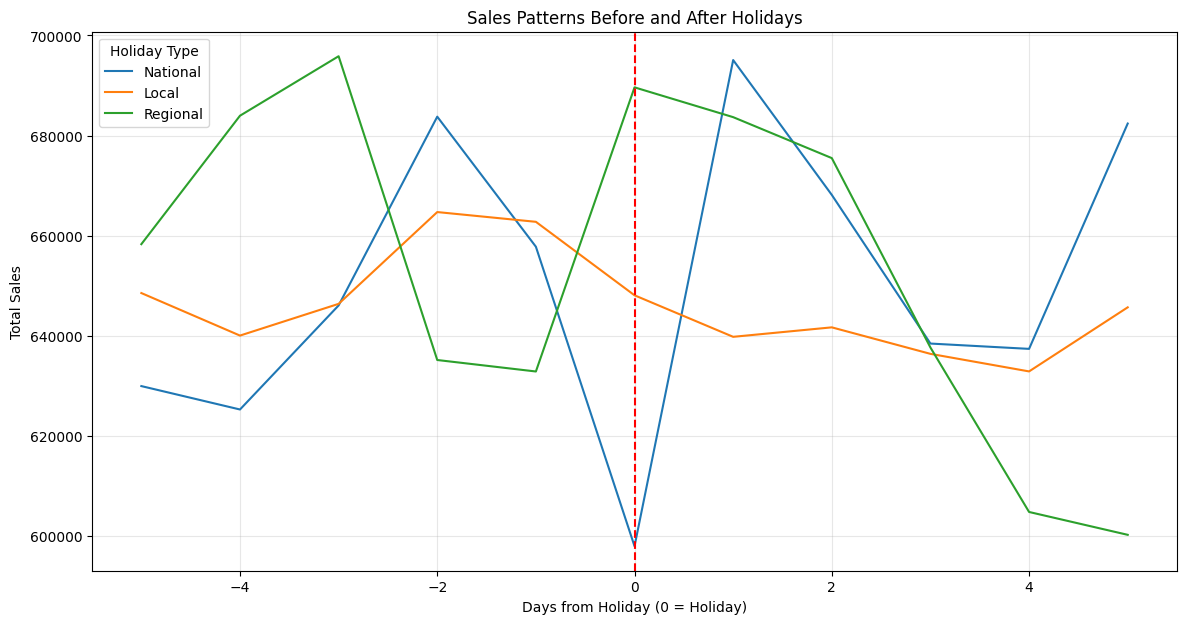

In [6]:
# Prepare data by converting transaction date to datetime
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

df_oil['date'] = pd.to_datetime(df_oil['date'])

# Create a function to analyze sales around holidays
def analyze_holiday_impact(holiday_date, days_before=7, days_after=7):
    """
    Analyzes sales before and after a holiday date
    Returns a DataFrame with daily sales for the period around the holiday
    """
    holiday_date = pd.to_datetime(holiday_date)
    start_date = holiday_date - pd.Timedelta(days=days_before)
    end_date = holiday_date + pd.Timedelta(days=days_after)
    
    # Get daily sales for the period
    mask = (daily_sales['date'] >= start_date) & (daily_sales['date'] <= end_date)
    period_sales = daily_sales[mask].copy()
    
    # Mark days relative to holiday
    period_sales['days_to_holiday'] = (period_sales['date'] - holiday_date).dt.days
    
    return period_sales

# Analyze major national holidays impact
national_holidays = df_holidays[df_holidays['locale'] == 'National'].copy()
major_holidays = national_holidays[~national_holidays['type'].isin(['Work Day', 'Additional', 'Transfer'])]

# Select a few important holidays for analysis
important_holidays = ['Primer dia del ano', 'Carnaval', 'Navidad']
holiday_dates = major_holidays[major_holidays['description'].isin(important_holidays)]['date'].unique()

# Create plot
plt.figure(figsize=(15, 10))

# Plot average sales patterns around holidays
for i, holiday_desc in enumerate(important_holidays):
    holiday_dates = major_holidays[major_holidays['description'] == holiday_desc]['date'].unique()
    
    # Get the most recent occurrence of each holiday (last 2 years)
    if len(holiday_dates) > 2:
        holiday_dates = sorted(holiday_dates)[-2:]
    
    avg_pattern = pd.DataFrame()
    
    for date in holiday_dates:
        impact_data = analyze_holiday_impact(date)
        if avg_pattern.empty:
            avg_pattern = impact_data.copy()
        else:
            # Combine data from multiple occurrences of the same holiday
            avg_pattern = pd.concat([
                avg_pattern, 
                impact_data[['days_to_holiday', 'sales']]
            ])
    
    # Group by days to holiday and calculate average
    avg_by_day = avg_pattern.groupby('days_to_holiday')['sales'].mean().reset_index()
    
    # Plot
    plt.subplot(3, 1, i+1)
    plt.plot(avg_by_day['days_to_holiday'], avg_by_day['sales'], marker='o')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.title(f'Sales Pattern Around {holiday_desc}')
    plt.xlabel('Days Relative to Holiday (0 = Holiday)')
    plt.ylabel('Average Sales')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare transaction volumes before/during/after holidays
# Merge transactions with holidays
df_transactions_holiday = pd.merge(
    df_transactions, 
    df_holidays[['date', 'type', 'locale', 'description']], 
    on='date', 
    how='left'
)

# Create holiday indicators (day before, holiday, day after)
df_transactions_holiday['holiday'] = ~df_transactions_holiday['type'].isna()
df_transactions_holiday['date'] = pd.to_datetime(df_transactions_holiday['date'])

# Add day of week
df_transactions_holiday['day_of_week'] = df_transactions_holiday['date'].dt.dayofweek

# Group by date and calculate averages
daily_transactions = df_transactions_holiday.groupby(['date', 'holiday', 'day_of_week'])['transactions'].mean().reset_index()

# Compare transactions on holidays vs non-holidays by day of week
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='transactions', hue='holiday', data=daily_transactions)
plt.title('Transaction Volumes: Holidays vs. Regular Days')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Transactions')
plt.legend(title='Is Holiday?')
plt.show()

# Analyze preparation effect (increased sales before holidays)
# Calculate daily total sales and merge with holidays
total_daily_sales = df_train.groupby('date')['sales'].sum().reset_index()
total_daily_sales['date'] = pd.to_datetime(total_daily_sales['date'])
holidays_only = df_holidays[df_holidays['type'] == 'Holiday'].copy()

# Create a DataFrame with holiday and days before/after
holiday_effect = pd.DataFrame()

for _, holiday in holidays_only.iterrows():
    holiday_date = holiday['date']
    for days_delta in range(-5, 6):  # -5 to +5 days around holiday
        target_date = holiday_date + pd.Timedelta(days=days_delta)
        if target_date in total_daily_sales['date'].values:
            sales_row = total_daily_sales[total_daily_sales['date'] == target_date].iloc[0]
            new_row = pd.DataFrame({
                'date': [target_date],
                'days_from_holiday': [days_delta],
                'sales': [sales_row['sales']],
                'holiday_name': [holiday['description']],
                'locale': [holiday['locale']]
            })
            holiday_effect = pd.concat([holiday_effect, new_row], ignore_index=True)

# Plot the effect of days before/after holiday on sales
plt.figure(figsize=(14, 7))
sns.lineplot(data=holiday_effect, x='days_from_holiday', y='sales', hue='locale', ci=None)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Sales Patterns Before and After Holidays')
plt.xlabel('Days from Holiday (0 = Holiday)')
plt.ylabel('Total Sales')
plt.grid(True, alpha=0.3)
plt.legend(title='Holiday Type')
plt.show()

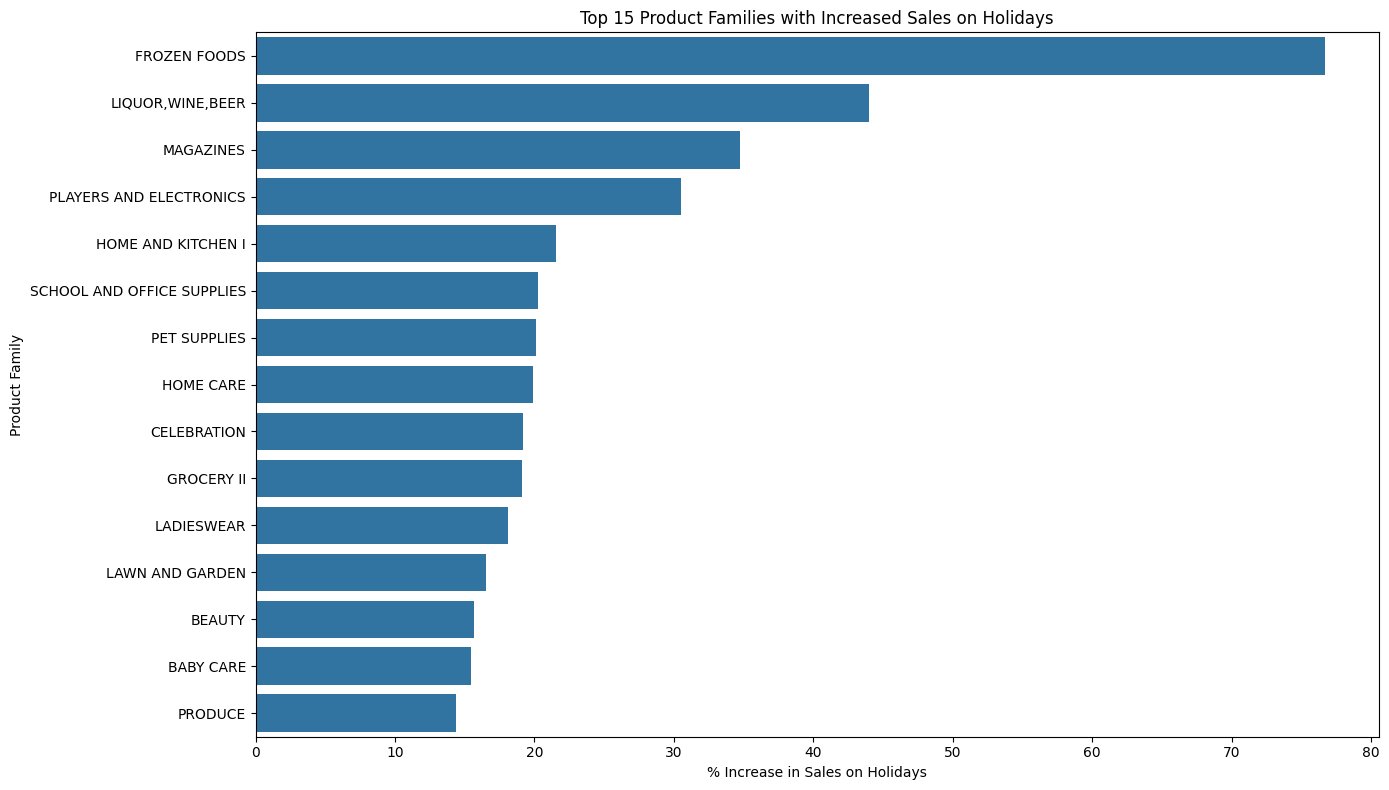

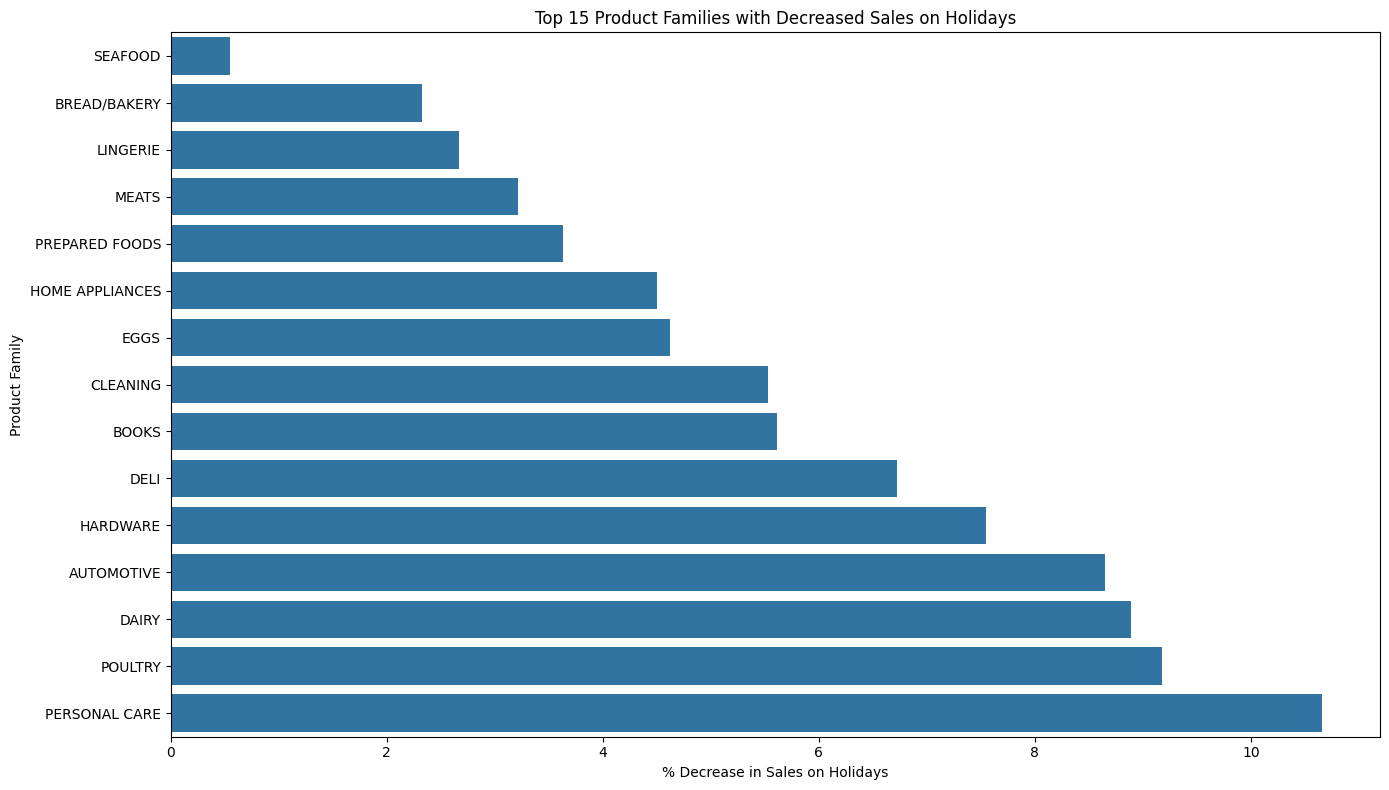

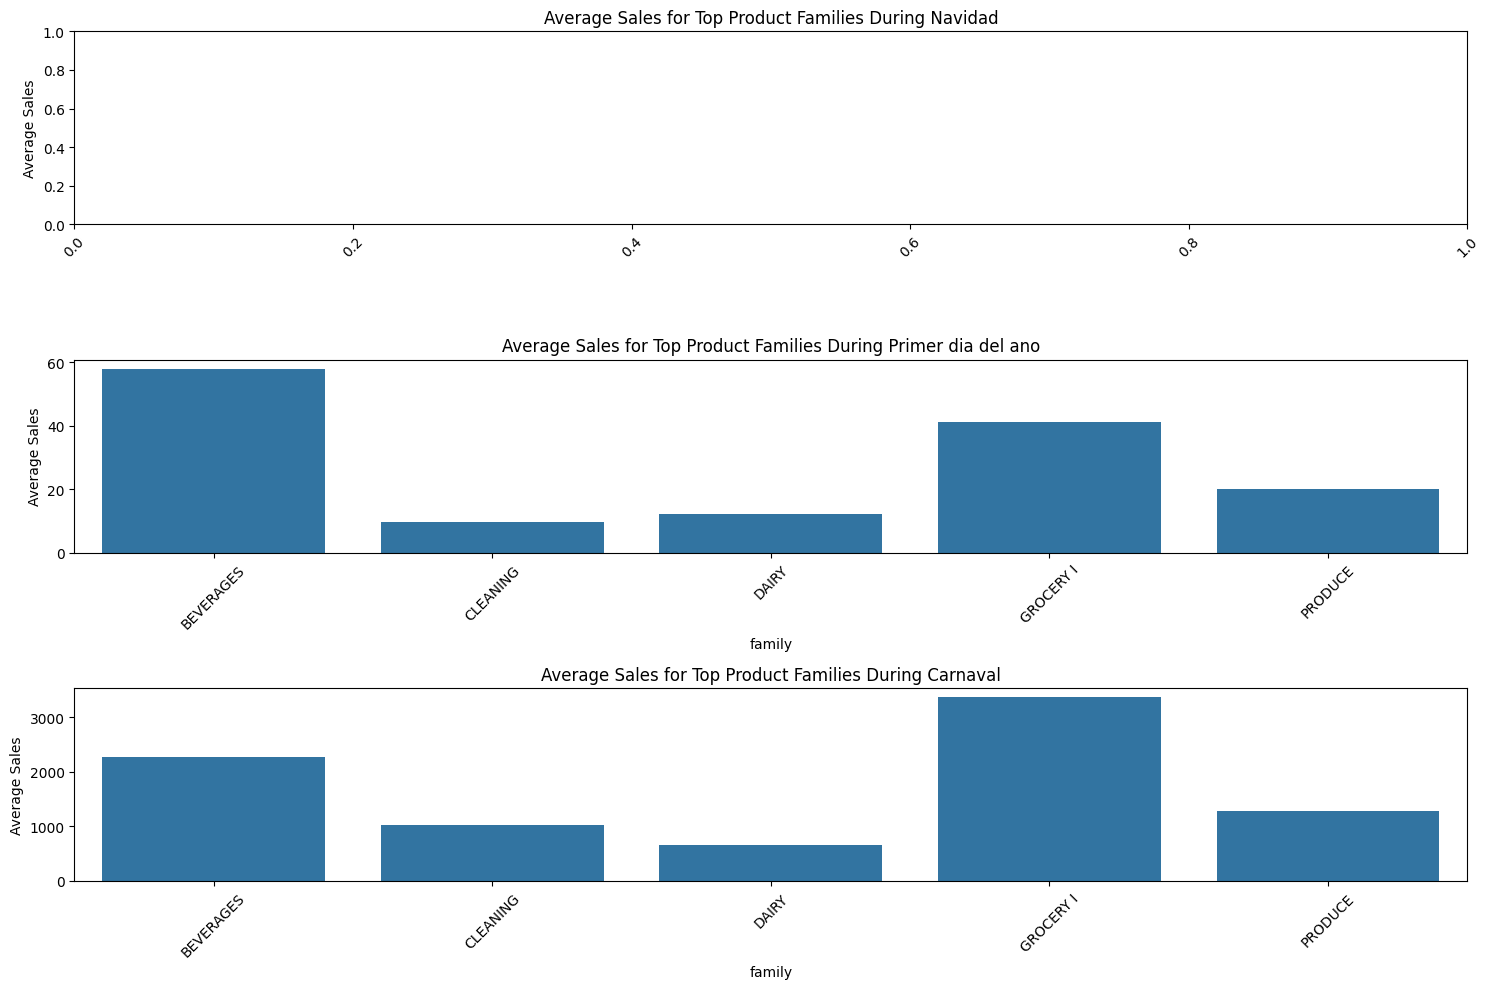

Top 10 Product Families Most Positively Affected by Holidays:
                       family  non_holiday_sales  holiday_sales  pct_change
0                FROZEN FOODS         140.513014     248.315581   76.720700
1            LIQUOR,WINE,BEER          79.964825     115.159706   44.012953
2                   MAGAZINES           2.799607       3.773181   34.775387
3     PLAYERS AND ELECTRONICS           5.936892       7.748555   30.515344
4          HOME AND KITCHEN I          19.877845      24.163515   21.560031
5  SCHOOL AND OFFICE SUPPLIES           2.869776       3.451537   20.272009
6                PET SUPPLIES           3.823790       4.591608   20.080027
7                   HOME CARE         171.673456     205.828540   19.895378
8                 CELEBRATION           8.164455       9.729511   19.169143
9                  GROCERY II          21.002897      25.010113   19.079350

Top 10 Product Families Most Negatively Affected by Holidays:
             family  non_holiday_sales 

In [7]:
# Check impact of holidays on different product families
# First, merge train data with holidays to identify holiday dates
train_with_holidays = pd.merge(df_train, df_holidays[['date', 'type', 'locale', 'description']], 
                              on='date', how='left')

# Create holiday flagf
train_with_holidays['is_holiday'] = ~train_with_holidays['type'].isna()

# Calculate average sales by family for holiday vs non-holiday
family_holiday_impact = train_with_holidays.groupby(['family', 'is_holiday'])['sales'].mean().reset_index()

# Pivot to compare holiday vs non-holiday for each family
family_impact_pivot = family_holiday_impact.pivot(index='family', 
                                                columns='is_holiday', 
                                                values='sales').reset_index()
family_impact_pivot.columns = ['family', 'non_holiday_sales', 'holiday_sales']

# Calculate percentage difference
family_impact_pivot['pct_change'] = ((family_impact_pivot['holiday_sales'] - 
                                     family_impact_pivot['non_holiday_sales']) / 
                                     family_impact_pivot['non_holiday_sales'] * 100)

# Sort by percentage difference to see most affected families
family_impact_sorted = family_impact_pivot.sort_values('pct_change', ascending=False).reset_index(drop=True)

# Plot top 15 most positively affected families
plt.figure(figsize=(14, 8))
top_families = family_impact_sorted.head(15)
sns.barplot(y='family', x='pct_change', data=top_families)
plt.title('Top 15 Product Families with Increased Sales on Holidays')
plt.xlabel('% Increase in Sales on Holidays')
plt.ylabel('Product Family')
plt.tight_layout()
plt.show()

# Plot bottom 15 most negatively affected families
plt.figure(figsize=(14, 8))
bottom_families = family_impact_sorted.tail(15).iloc[::-1]
sns.barplot(y='family', x='pct_change', data=bottom_families)
plt.title('Top 15 Product Families with Decreased Sales on Holidays')
plt.xlabel('% Decrease in Sales on Holidays')
plt.ylabel('Product Family')
plt.tight_layout()
plt.show()

# Look at specific holiday types and their impact on top product families
# Focus on major holidays like Christmas, New Year, and Carnival
major_holiday_names = ['Navidad', 'Primer dia del ano', 'Carnaval']
major_holidays_data = train_with_holidays[train_with_holidays['description'].isin(major_holiday_names)]

# Top 5 families by sales overall
top_families_overall = df_train.groupby('family')['sales'].sum().sort_values(ascending=False).head(5).index

# Create a plot showing sales for top families during major holidays
plt.figure(figsize=(15, 10))

for i, holiday in enumerate(major_holiday_names):
    plt.subplot(3, 1, i+1)
    holiday_data = major_holidays_data[major_holidays_data['description'] == holiday]
    
    # Aggregate sales by family for this holiday
    family_sales = holiday_data[holiday_data['family'].isin(top_families_overall)].groupby('family')['sales'].mean()
    
    sns.barplot(x=family_sales.index, y=family_sales.values)
    plt.title(f'Average Sales for Top Product Families During {holiday}')
    plt.ylabel('Average Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Top 10 Product Families Most Positively Affected by Holidays:")
print(family_impact_sorted[['family', 'non_holiday_sales', 'holiday_sales', 'pct_change']].head(10))
print("\nTop 10 Product Families Most Negatively Affected by Holidays:")
print(family_impact_sorted[['family', 'non_holiday_sales', 'holiday_sales', 'pct_change']].tail(10).iloc[::-1])

In [8]:
# Merge train data with holidays data
df_train = pd.merge(
    df_train,
    df_holidays[['date', 'type', 'locale', 'description', 'transferred']],
    on='date',
    how='left'
)

# Display first few rows to check the merge
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,type,locale,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Primer dia del ano,False


Holiday Feature Engineering

In [9]:
df_train['is_national_holiday'] = df_train['type'].apply(lambda x: 1 if x == 'National' else 0)
df_train['is_regional_holiday'] = df_train['type'].apply(lambda x: 1 if x == 'Regional' else 0)
df_train['is_local_holiday'] = df_train['type'].apply(lambda x: 1 if x == 'Local' else 0)
df_train['is_transferred'] = df_train['transferred'].apply(lambda x: 1 if x else 0)

Codificando dias antes e depois do feriado

In [10]:
# Create columns for holiday proximity (4 days before and 4 days after)
for days_shift in range(-4, 5):
    if days_shift == 0:  # Skip the actual holiday day (already captured in existing columns)
        continue
        
    # Create column name based on sign (holiday-1, holiday+2, etc)
    sign = "+" if days_shift > 0 else ""
    col_name = f"holiday{sign}{days_shift}"
    
    # Initialize columns with zeros
    df_train[col_name] = 0
    df_test[col_name] = 0

# Fill in the proximity values
holiday_dates = df_holidays[df_holidays['type'] == 'Holiday']['date'].unique()

# For train dataset
for holiday_date in holiday_dates:
    for days_shift in range(-4, 5):
        if days_shift == 0:
            continue
            
        target_date = holiday_date + pd.Timedelta(days=days_shift)
        sign = "+" if days_shift > 0 else ""
        col_name = f"holiday{sign}{days_shift}"
        
        # Set 1 for rows that match the target date
        df_train.loc[df_train['date'] == target_date, col_name] = 1

# For test dataset
for holiday_date in holiday_dates:
    for days_shift in range(-4, 5):
        if days_shift == 0:
            continue
            
        target_date = holiday_date + pd.Timedelta(days=days_shift)
        sign = "+" if days_shift > 0 else ""
        col_name = f"holiday{sign}{days_shift}"
        
        # Set 1 for rows that match the target date
        df_test.loc[df_test['date'] == target_date, col_name] = 1

# Display first few rows with new columns to verify
print("Train data with holiday proximity columns:")
print(df_train[['date', 'is_national_holiday', 'is_regional_holiday', 'is_local_holiday', 
               'holiday-4', 'holiday-3', 'holiday-2', 'holiday-1',
               'holiday+1', 'holiday+2', 'holiday+3', 'holiday+4']].sample(5))

Train data with holiday proximity columns:
              date  is_national_holiday  is_regional_holiday  \
216095  2013-05-02                    0                    0   
1455695 2015-03-19                    0                    0   
984362  2014-06-30                    0                    0   
3021185 2017-07-28                    0                    0   
469480  2013-09-17                    0                    0   

         is_local_holiday  holiday-4  holiday-3  holiday-2  holiday-1  \
216095                  0          0          0          0          0   
1455695                 0          0          0          0          0   
984362                  0          0          1          0          0   
3021185                 0          0          0          0          0   
469480                  0          0          0          0          0   

         holiday+1  holiday+2  holiday+3  holiday+4  
216095           1          0          1          0  
1455695          0       

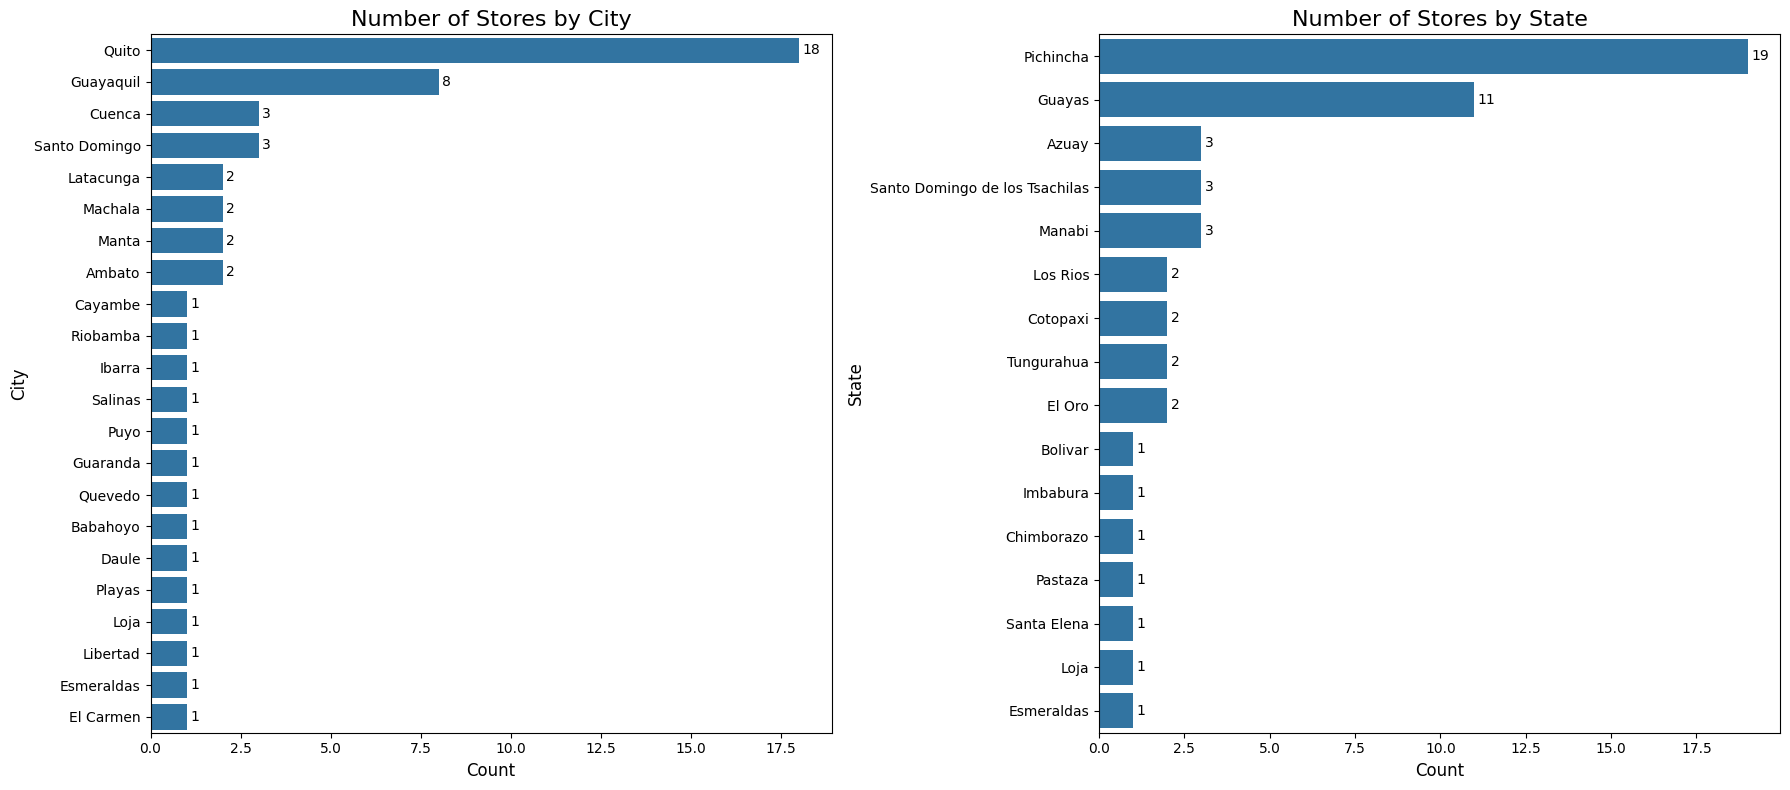


Store Count by City:
city
Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Latacunga         2
Machala           2
Manta             2
Ambato            2
Cayambe           1
Riobamba          1
Ibarra            1
Salinas           1
Puyo              1
Guaranda          1
Quevedo           1
Babahoyo          1
Daule             1
Playas            1
Loja              1
Libertad          1
Esmeraldas        1
El Carmen         1
Name: count, dtype: int64

Store Count by State:
state
Pichincha                         19
Guayas                            11
Azuay                              3
Santo Domingo de los Tsachilas     3
Manabi                             3
Los Rios                           2
Cotopaxi                           2
Tungurahua                         2
El Oro                             2
Bolivar                            1
Imbabura                           1
Chimborazo                         1
Pastaza                           

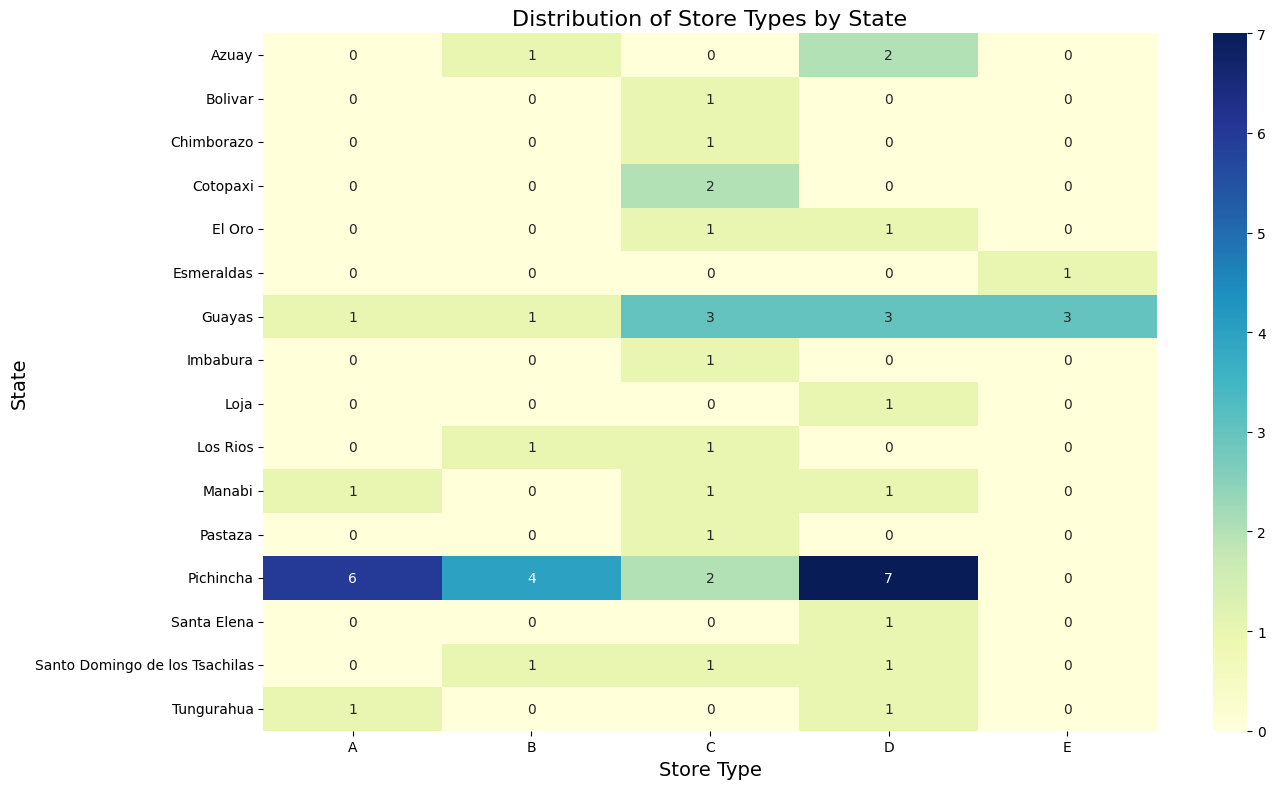

In [11]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Count stores by city
city_counts = df_stores['city'].value_counts().sort_values(ascending=False)
city_plot = sns.barplot(x=city_counts.values, y=city_counts.index, ax=ax1)
ax1.set_title('Number of Stores by City', fontsize=16)
ax1.set_xlabel('Count', fontsize=12)
ax1.set_ylabel('City', fontsize=12)

# Add count numbers to the city bars
for i, v in enumerate(city_counts.values):
    ax1.text(v + 0.1, i, str(v), va='center')

# Count stores by state
state_counts = df_stores['state'].value_counts().sort_values(ascending=False)
state_plot = sns.barplot(x=state_counts.values, y=state_counts.index, ax=ax2)
ax2.set_title('Number of Stores by State', fontsize=16)
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('State', fontsize=12)

# Add count numbers to the state bars
for i, v in enumerate(state_counts.values):
    ax2.text(v + 0.1, i, str(v), va='center')

plt.tight_layout()
plt.show()

# Display the numerical data as well
print("\nStore Count by City:")
print(city_counts)

print("\nStore Count by State:")
print(state_counts)

# Create a choropleth-style heatmap of store types by state
store_type_by_state = pd.crosstab(df_stores['state'], df_stores['type'])
plt.figure(figsize=(14, 8))
sns.heatmap(store_type_by_state, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Distribution of Store Types by State', fontsize=16)
plt.ylabel('State', fontsize=14)
plt.xlabel('Store Type', fontsize=14)
plt.tight_layout()
plt.show()

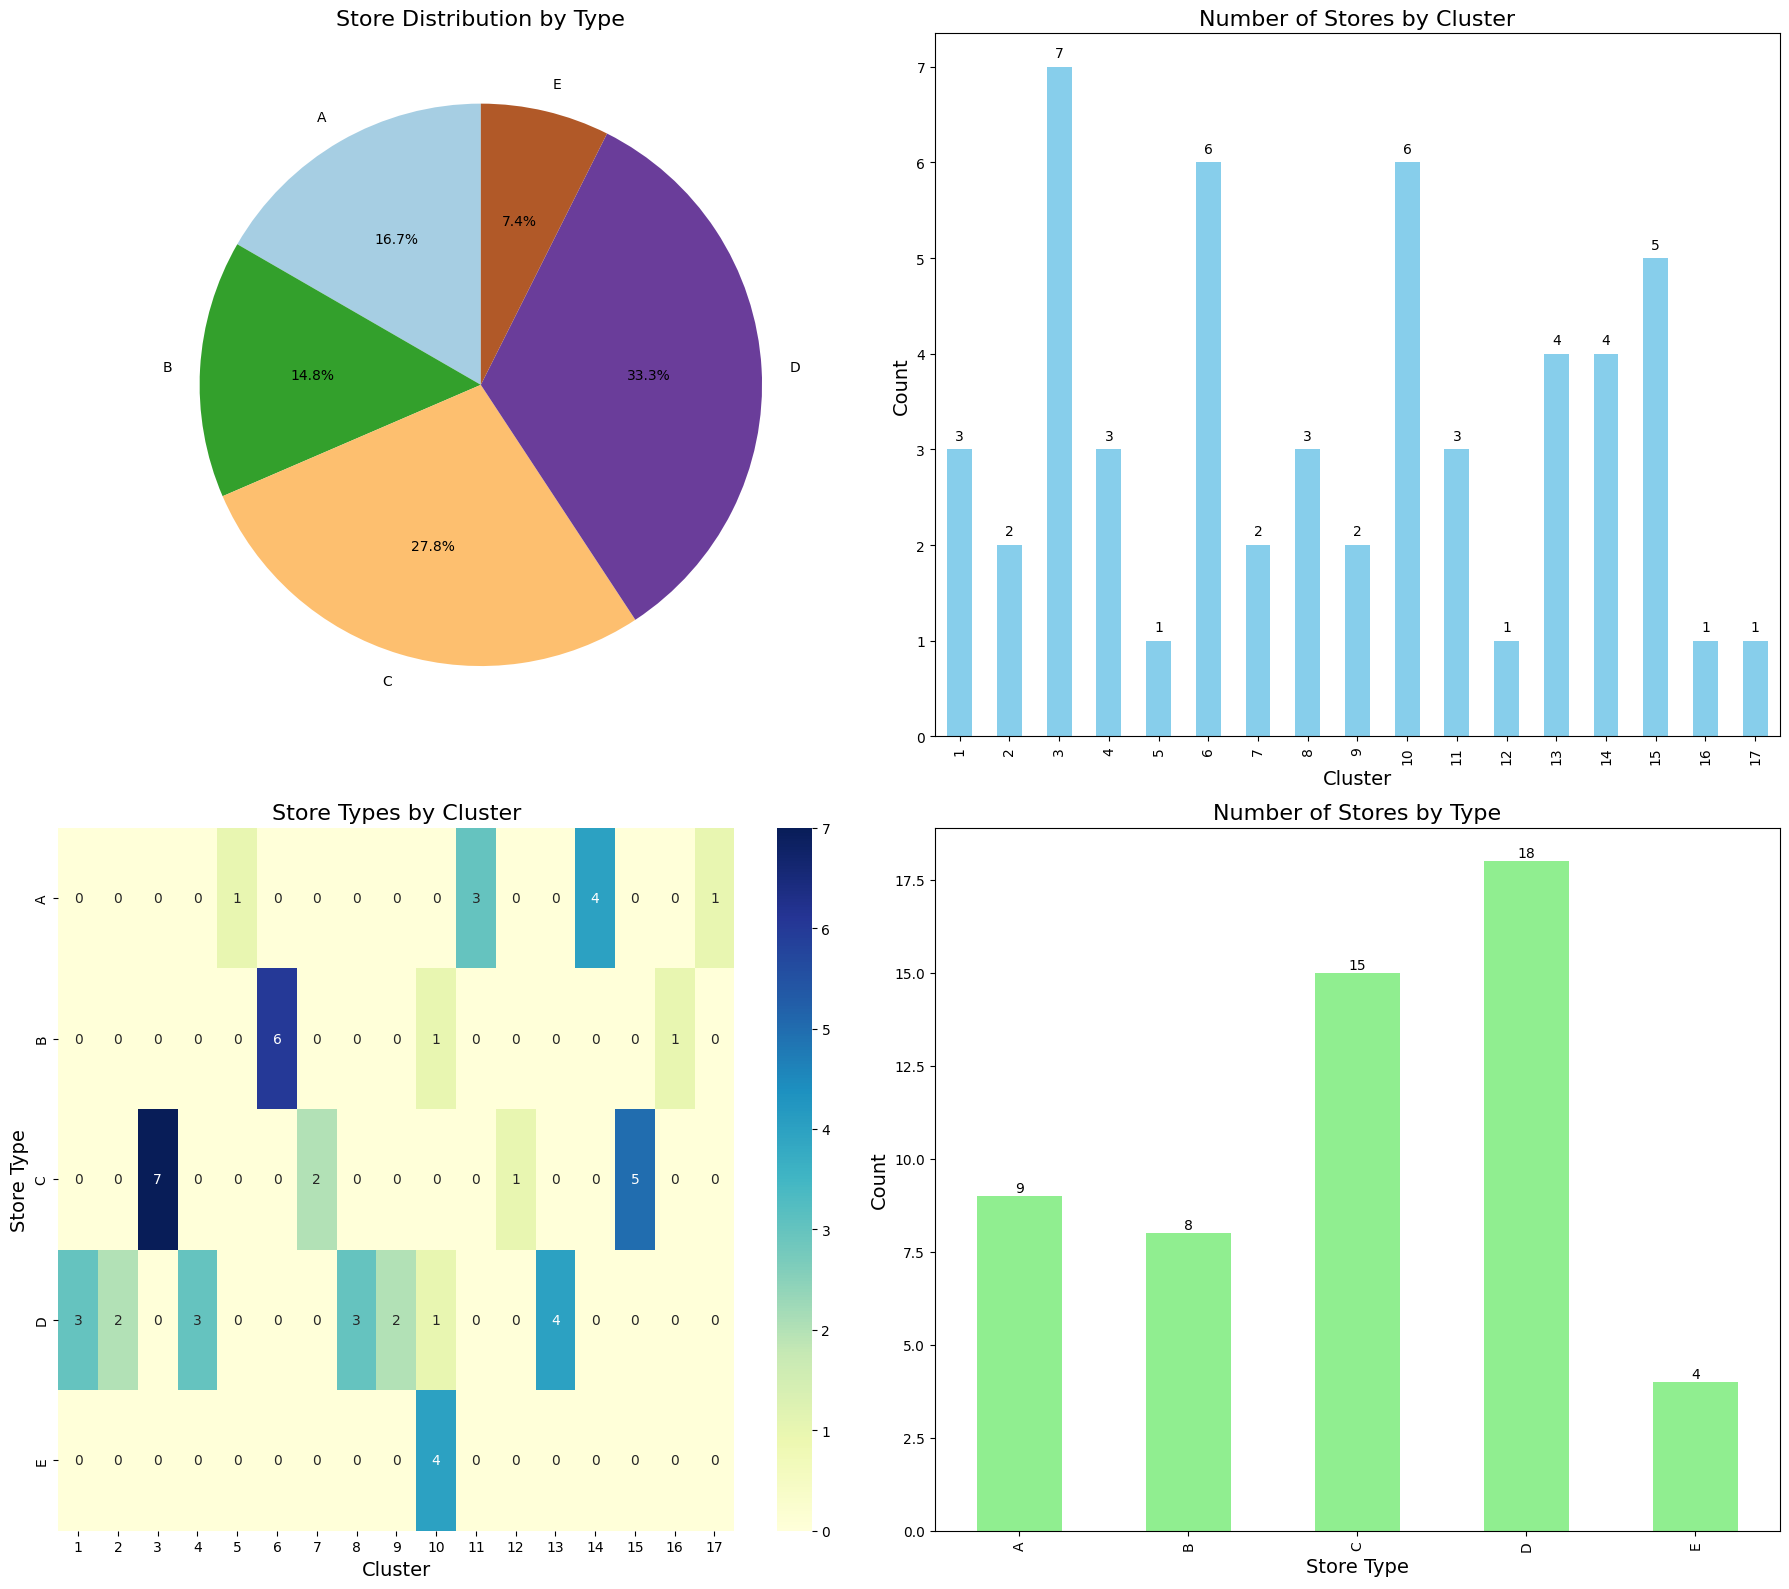

Store Count by Type:
type
A     9
B     8
C    15
D    18
E     4
Name: count, dtype: int64

Store Count by Cluster:
cluster
1     3
2     2
3     7
4     3
5     1
6     6
7     2
8     3
9     2
10    6
11    3
12    1
13    4
14    4
15    5
16    1
17    1
Name: count, dtype: int64

Summary Statistics:
Total number of stores: 54
Most common store type: D (18 stores)
Most common cluster: Cluster 3 (7 stores)
Number of unique clusters: 17


In [16]:
# Create a figure with multiple subplots for different visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Count stores by type
store_type_counts = df_stores['type'].value_counts().sort_index()
type_ax = axes[0, 0]
store_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=type_ax, 
                      colors=plt.cm.Paired(np.linspace(0, 1, len(store_type_counts))))
type_ax.set_title('Store Distribution by Type', fontsize=16)
type_ax.set_ylabel('')  # Remove y-label for pie chart

# Count stores by cluster
store_cluster_counts = df_stores['cluster'].value_counts().sort_index()
cluster_ax = axes[0, 1]
store_cluster_counts.plot(kind='bar', ax=cluster_ax, color='skyblue')
cluster_ax.set_title('Number of Stores by Cluster', fontsize=16)
cluster_ax.set_xlabel('Cluster', fontsize=14)
cluster_ax.set_ylabel('Count', fontsize=14)
# Add count labels to the bars
for i, v in enumerate(store_cluster_counts):
    cluster_ax.text(i, v + 0.1, str(v), ha='center')

# Create cross-tabulation of type and cluster to see their relationship
type_cluster_cross = pd.crosstab(df_stores['type'], df_stores['cluster'])
cross_ax = axes[1, 0]
sns.heatmap(type_cluster_cross, annot=True, fmt='d', cmap='YlGnBu', ax=cross_ax)
cross_ax.set_title('Store Types by Cluster', fontsize=16)
cross_ax.set_xlabel('Cluster', fontsize=14)
cross_ax.set_ylabel('Store Type', fontsize=14)

# Bar chart showing total stores by type
bar_ax = axes[1, 1]
store_type_counts.plot(kind='bar', ax=bar_ax, color='lightgreen')
bar_ax.set_title('Number of Stores by Type', fontsize=16)
bar_ax.set_xlabel('Store Type', fontsize=14)
bar_ax.set_ylabel('Count', fontsize=14)
# Add count labels to the bars
for i, v in enumerate(store_type_counts):
    bar_ax.text(i, v + 0.1, str(v), ha='center')

plt.tight_layout()
plt.show()

# Display the numeric data as well
print("Store Count by Type:")
print(store_type_counts)
print("\nStore Count by Cluster:")
print(store_cluster_counts)

# Statistics summary
print("\nSummary Statistics:")
print(f"Total number of stores: {len(df_stores)}")
print(f"Most common store type: {df_stores['type'].value_counts().index[0]} ({df_stores['type'].value_counts().iloc[0]} stores)")
print(f"Most common cluster: Cluster {df_stores['cluster'].value_counts().index[0]} ({df_stores['cluster'].value_counts().iloc[0]} stores)")
print(f"Number of unique clusters: {df_stores['cluster'].nunique()}")